In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
from tensorflow.python.keras import layers
import tensorflow_probability as tfp
from tensorflow.python.keras.callbacks import Callback
from sklearn.model_selection import train_test_split


import functions.parse_data as parse
import functions.models as md
import functions.handy_functions as hf

2024-01-31 11:49:45.119724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])

print(data_all.isnull().sum().sum())

## Train 5 layer model with 64 neurons per hidden layer.

In [73]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.

y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13','COT']

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)
num_epochs=20
batch_size=100
model, history_df, X_test,y_test=md.train_5layer_64neurons_model(df,x_labels=X_labels,y_labels=y_labels,split=[0.6,0.2,0.2],epochs=num_epochs,batch_size=batch_size)

Epoch 1/20
1280/1280 [==============================] - 86s 66ms/step - loss: 3.7943 - mse: 3.7943 - val_loss: 1.4950 - val_mse: 1.4950
Epoch 2/20
1280/1280 [==============================] - 74s 57ms/step - loss: 1.2928 - mse: 1.2928 - val_loss: 1.2085 - val_mse: 1.2085
Epoch 3/20
1280/1280 [==============================] - 77s 60ms/step - loss: 1.0741 - mse: 1.0741 - val_loss: 0.9892 - val_mse: 0.9892
Epoch 4/20
1280/1280 [==============================] - 80s 63ms/step - loss: 0.9875 - mse: 0.9875 - val_loss: 0.8606 - val_mse: 0.8606
Epoch 5/20
1280/1280 [==============================] - 77s 60ms/step - loss: 0.9034 - mse: 0.9034 - val_loss: 0.9180 - val_mse: 0.9180
Epoch 6/20
1280/1280 [==============================] - 89s 70ms/step - loss: 0.8627 - mse: 0.8627 - val_loss: 0.8200 - val_mse: 0.8200
Epoch 7/20
1280/1280 [==============================] - 75s 59ms/step - loss: 0.8098 - mse: 0.8098 - val_loss: 0.9801 - val_mse: 0.9801
Epoch 8/20
1280/1280 [==========================

In [74]:
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=2)
print(f"Test mse: {test_mse}")

1250/1250 - 15s - loss: 0.4942 - mse: 0.4942 - 15s/epoch - 12ms/step
Test mse: 0.4941917359828949


In [75]:
y_predict=model.predict(X_test)

1250/1250 [==============================] - 12s 9ms/step


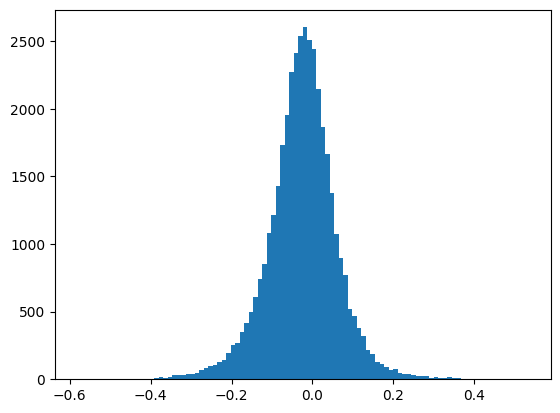

In [97]:
y_test_np=y_test.to_numpy()
channel=2
plt.hist(y_predict[:,channel]-y_test_np[:,channel],bins=100)
plt.show()

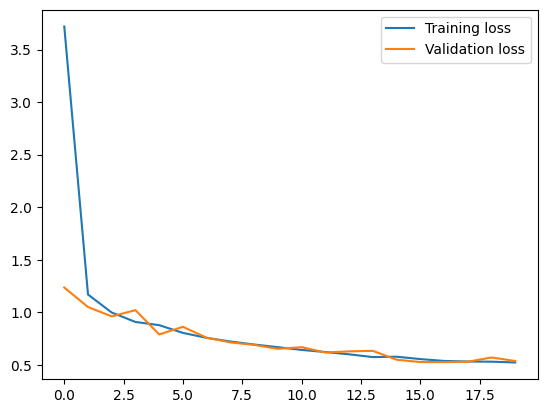

In [26]:
plt.plot(history_df['training_loss'])
plt.plot(history_df['validation_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.show()

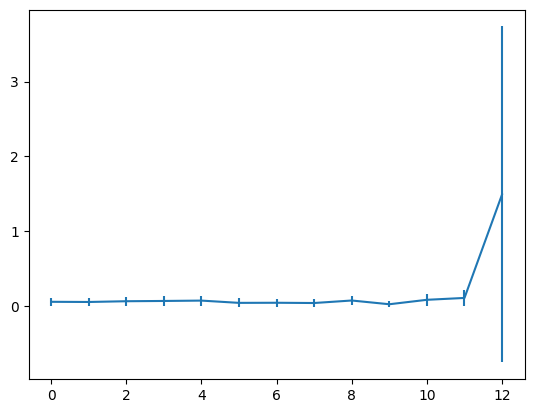

In [35]:
err = np.abs(y_predict[:,:]-y_test_np[:,:])
RMSE = np.mean(err,axis=0)
err_sdev = np.sqrt(np.var(err,axis=0))
x = range(13)
plt.figure()
plt.errorbar(x, RMSE, yerr=err_sdev)
plt.show()


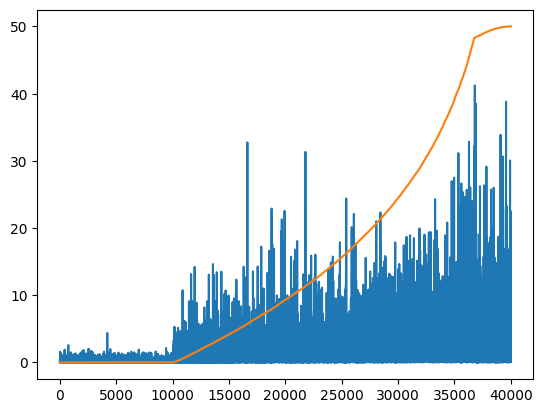

[39999 15206 15207 ... 18985  4077 11305]


In [67]:
err_COTsort = err[y_test_np[:, 12].argsort()]

plt.figure()
plt.plot(err_COTsort[:,12])
plt.plot(y_test_np[y_test_np[:,12].argsort()][:,12])
plt.show()


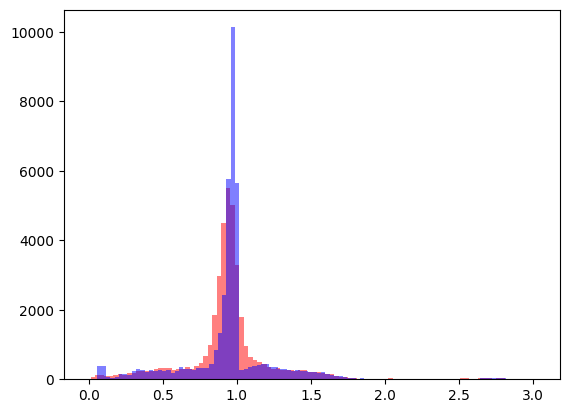

In [103]:
channel=5
plt.figure()
plt.hist(y_predict[:,channel],bins=100,alpha=0.5,color='red')
plt.hist(y_test_np[:,channel],bins=100,alpha=0.5,color='blue')
plt.show()

Testing to model cloud instead of clear ground:

In [83]:
#df['Diff_B02','Diff_B03','Diff_B04','Diff_B05','Diff_B06','Diff_B07','Diff_B08','Diff_B09','Diff_B10','Diff_B11', \
#   'Diff_B12','Diff_B13'] = \
#   df['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06', 'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10', \
#      'Cloud_B11','Cloud_B12','Cloud_B13'] - \
#   df['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06', 'Clear_B07','Clear_B08','Clear_B09','Clear_B10', \
#      'Clear_B11','Clear_B12','Clear_B13']
cloudcols = ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']
clearcols = ['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']
diffcols = ['Diff_B02','Diff_B03','Diff_B04','Diff_B05','Diff_B06',
            'Diff_B07','Diff_B08','Diff_B09','Diff_B10','Diff_B11','Diff_B12','Diff_B13']

data_all[diffcols] = data_all[cloudcols] - df[clearcols].values



In [84]:
y_labels2=['Diff_B02','Diff_B03','Diff_B04','Diff_B05','Diff_B06',
          'Diff_B07','Diff_B08','Diff_B09','Diff_B10','Diff_B11','Diff_B12','Diff_B13','COT']

model2, history_df2, X_test2,y_test2=md.train_5layer_64neurons_model(df,x_labels=X_labels,y_labels=y_labels2,split=[0.6,0.2,0.2],epochs=num_epochs,batch_size=batch_size)

Epoch 1/20
1280/1280 [==============================] - 78s 61ms/step - loss: 3.8276 - mse: 3.8276 - val_loss: 1.4010 - val_mse: 1.4010
Epoch 2/20
1280/1280 [==============================] - 73s 57ms/step - loss: 1.2473 - mse: 1.2473 - val_loss: 1.1218 - val_mse: 1.1218
Epoch 3/20
1280/1280 [==============================] - 70s 55ms/step - loss: 1.0123 - mse: 1.0123 - val_loss: 0.9853 - val_mse: 0.9853
Epoch 4/20
1280/1280 [==============================] - 72s 56ms/step - loss: 0.9194 - mse: 0.9194 - val_loss: 0.8635 - val_mse: 0.8635
Epoch 5/20
1280/1280 [==============================] - 75s 59ms/step - loss: 0.8551 - mse: 0.8551 - val_loss: 0.8134 - val_mse: 0.8134
Epoch 6/20
1280/1280 [==============================] - 75s 58ms/step - loss: 0.8220 - mse: 0.8220 - val_loss: 0.7386 - val_mse: 0.7386
Epoch 7/20
1280/1280 [==============================] - 75s 58ms/step - loss: 0.7734 - mse: 0.7734 - val_loss: 0.7267 - val_mse: 0.7267
Epoch 8/20
1280/1280 [==========================

In [86]:
test_loss2, test_mse2 = model2.evaluate(X_test2, y_test2, verbose=2)
print(f"Test mse: {test_mse2}")

1250/1250 - 14s - loss: 0.5608 - mse: 0.5608 - 14s/epoch - 11ms/step
Test mse: 0.5607823133468628


## Train a first bayesian network

In [68]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.

y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13','COT']

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)
num_epochs=5
batch_size=100
model, history_df, X_test,y_test=md.train_first_bayesian_model(df,x_labels=X_labels,y_labels=y_labels,split=[0.6,0.2,0.2],epochs=num_epochs,batch_size=batch_size)

Epoch 1/5
1280/1280 [==============================] - 106s 82ms/step - loss: 162.1680 - mse: 14.4046 - val_loss: 35.5160 - val_mse: 8.1928
Epoch 2/5
1280/1280 [==============================] - 89s 70ms/step - loss: 18.5023 - mse: 7.4893 - val_loss: 10.8078 - val_mse: 6.8885
Epoch 3/5
1280/1280 [==============================] - 99s 77ms/step - loss: 9.6272 - mse: 6.8140 - val_loss: 9.2320 - val_mse: 6.9259
Epoch 4/5
1280/1280 [==============================] - 116s 91ms/step - loss: 8.5954 - mse: 6.5398 - val_loss: 8.3978 - val_mse: 6.4298
Epoch 5/5
1280/1280 [==============================] - 127s 100ms/step - loss: 8.3016 - mse: 6.3090 - val_loss: 8.2632 - val_mse: 6.3516


In [69]:
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=2)
print(f"Test mse: {test_mse}")

1250/1250 - 40s - loss: 8.1092 - mse: 6.1743 - 40s/epoch - 32ms/step
Test mse: 6.174278736114502


In [70]:
y_predict=model.predict(X_test)

1250/1250 [==============================] - 43s 35ms/step


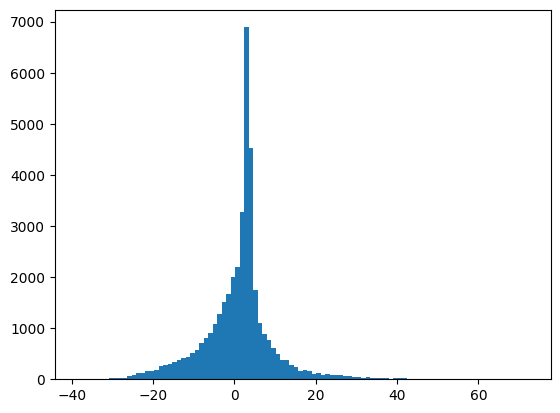

In [71]:
y_test_np=y_test.to_numpy()
channel=12
plt.hist(y_predict[:,channel]-y_test_np[:,channel],bins=100)
plt.show()

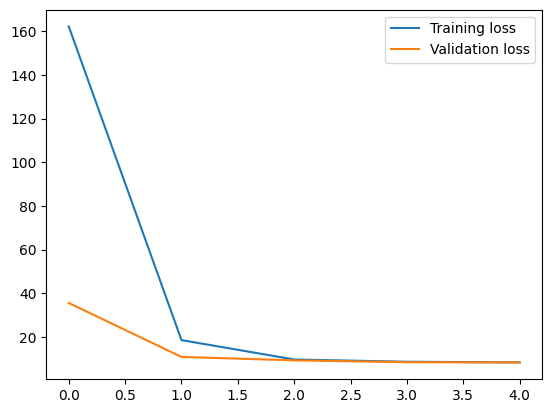

In [72]:
plt.plot(history_df['training_loss'])
plt.plot(history_df['validation_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.show()